# 02 - Exploratory Data Analysis 📊

## Problem

How can we generate short descriptions including a list of popular beer styles from brewery reviews with natural language processing (NLP)? 

NOTE: This is similar to how Google Maps provides short blurbs for businesses such as “From scratch, Northern Italian dining.” 

For example, "Spacious warehouse brewery with daily food trucks. Allows dogs. Features IPAs, Hazy IPAs, and high-gravity stouts."

## Notebook Objectives

* Understand the importance of performing EDA on data science projects. 
* Apply data wrangling techniques, as laid out in the DSM building data profiles, tables, and figures to evaluate the feature relationships.
* Identify the features that are likely to have the most impact in modeling based on relationships between the features and the response variable.

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import time
from tqdm.notebook import tqdm

# Load NLP model
nlp = spacy.load("en_core_web_md")

# Initialize TQDM
tqdm.pandas(desc="progress bar")

%matplotlib inline

/Users/chris/opt/anaconda3/envs/brewery-review-nlp/lib/python3.9/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# Create DataFrame from DB data
db = sqlite3.connect('../data/raw/brewery_reviews.db')
query = """
    SELECT r.text as review_text, r.rating, r.date, b.name as brewery_name, b.street, c.name as city
    FROM reviews r
    JOIN brewery b
    ON r.ba_brewery_id = b.ba_brewery_id
    JOIN cities c
    ON c.id = b.city_id
"""
df = pd.read_sql_query(query, db, parse_dates=['date'])

In [4]:
# Review DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45417 entries, 0 to 45416
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   review_text   45417 non-null  object        
 1   rating        45417 non-null  float64       
 2   date          45417 non-null  datetime64[ns]
 3   brewery_name  45417 non-null  object        
 4   street        45417 non-null  object        
 5   city          45417 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 2.1+ MB


In [5]:
# Inspect
df.head()

,review_text,rating,date,brewery_name,street,city
0,Got to visit the newest brewery in Birmingham ...,4.13,2019-07-25,Birmingham District Brewing,"2201 2nd Ave S, Ste 102",Birmingham
1,"Nice big space, very clean, and friendly staff...",4.04,2018-10-23,Trimtab Brewing Company,2721 5th Ave S,Birmingham
2,The vibe of trim tab is interesting.....they h...,4.04,2018-08-24,Trimtab Brewing Company,2721 5th Ave S,Birmingham
3,"Stopped here late one night before closing, th...",4.07,2017-07-11,Trimtab Brewing Company,2721 5th Ave S,Birmingham
4,Extremely relaxed brewery. Great service with ...,4.10,2018-01-21,Trimtab Brewing Company,2721 5th Ave S,Birmingham


In [6]:
# Unique cities
df['city'].unique()

array(['Birmingham', 'Anchorage', 'Phoenix', 'Los Angeles', 'San Diego',
       'San Francisco', 'Boulder', 'Denver', 'Fort Collins', 'Hartford',
       'Wilmington', 'Washington', 'Jacksonville', 'Orlando', 'Tampa',
       'Atlanta', 'Honolulu', 'Chicago', 'Indianapolis', 'Des Moines',
       'New Orleans', 'Portland', 'Baltimore', 'Boston', 'Detroit',
       'Grand Rapids', 'Minneapolis', 'Kansas City', 'Saint Louis',
       'Omaha', 'Las Vegas', 'Portsmouth', 'Albuquerque', 'Buffalo',
       'New York City (NYC)', 'Rochester', 'Asheville', 'Charlotte',
       'Greensboro', 'Raleigh', 'Cincinnati', 'Cleveland', 'Columbus',
       'Bend', 'Eugene', 'Philadelphia', 'Pittsburgh', 'Providence',
       'Charleston', 'Nashville', 'Austin', 'Dallas', 'Houston',
       'San Antonio', 'Salt Lake City', 'Burlington', 'Alexandria',
       'Richmond', 'Seattle', 'Madison', 'Milwaukee', 'Melbourne',
       'Sydney', 'Antwerpen', 'Brugge', 'Brussels', 'Gent', 'Calgary',
       'Edmonton', 'Montréa

In [8]:
# Unique Breweries
len(df['brewery_name'].unique())

4522

In [14]:
# Date range by month
date_range_month = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='M')
date_range_month

DatetimeIndex(['2002-03-31', '2002-04-30', '2002-05-31', '2002-06-30',
               '2002-07-31', '2002-08-31', '2002-09-30', '2002-10-31',
               '2002-11-30', '2002-12-31',
               ...
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30',
               '2020-10-31', '2020-11-30'],
              dtype='datetime64[ns]', length=225, freq='M')

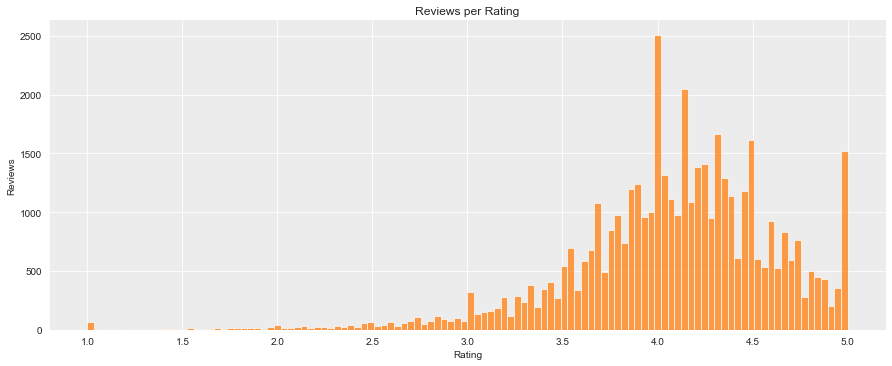

In [209]:
sns.set_style("darkgrid", {"axes.facecolor": ".925"})
sns.displot(data=df, x='rating', color='tab:orange', aspect=2.5)
plt.xlabel('Rating')
plt.ylabel('Reviews')
plt.title('Reviews per Rating')
plt.savefig('../reports/figures/reviews-per-rating.png')
plt.show()

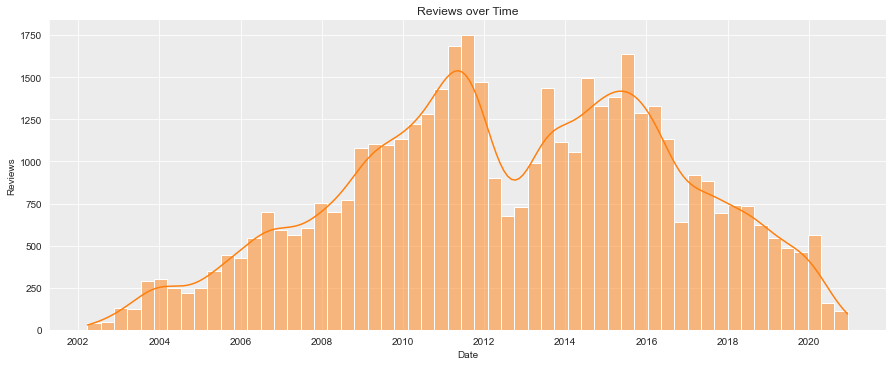

In [213]:
sns.set_style("darkgrid", {"axes.facecolor": ".925"})
sns.displot(data=df, x='date', color="tab:orange", aspect=2.5, kde=True)
plt.xlabel('Date')
plt.ylabel('Reviews')
plt.title('Reviews over Time')
plt.savefig('../reports/figures/reviews-over-time.png')
plt.show()

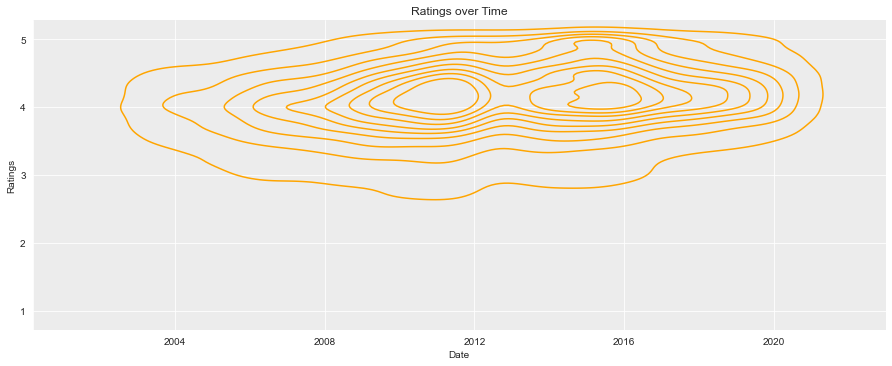

In [235]:
sns.set_style("darkgrid", {"axes.facecolor": ".925"})
sns.displot(data=df, x='date', y='rating', color="orange", aspect=2.5, kind="kde")
plt.xlabel('Date')
plt.ylabel('Ratings')
plt.title('Ratings over Time')
plt.savefig('../reports/figures/ratings-over-time-kde.png')
plt.show()

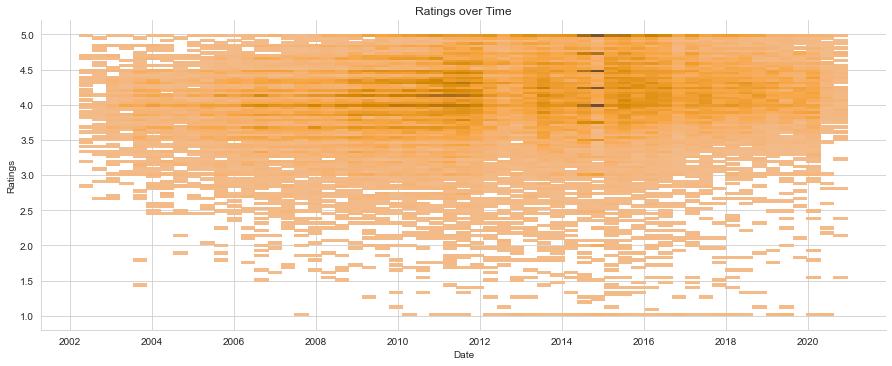

In [234]:
sns.set_style("whitegrid")
sns.displot(data=df, x='date', y='rating', color="orange", aspect=2.5)
plt.xlabel('Date')
plt.ylabel('Ratings')
plt.title('Ratings over Time')
plt.savefig('../reports/figures/ratings-over-time.png')
plt.show()

In [11]:
# Count the words
# WARNING: THIS TAKES A LONG TIME (~8 minutes)
df['tokens'] = df['review_text'].progress_apply(lambda x: len(nlp(x)))

In [12]:
# Count the sentences
# WARNING: THIS TAKES A LONG TIME (~9 minutes)
df['sents'] = df['review_text'].progress_apply(lambda x: len(list(nlp(x).sents)))

In [122]:
# Sentiment analysis
# NB: I'm using TextBlob here because spaCy wasn't returning any sentiment and I'm not sure why. Plus it's MUCH faster.
df['sentiment'] = df['review_text'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

In [124]:
# Save as CSV
df.to_csv('../data/processed/brewery_reviews.csv')

In [7]:
df_reviews = pd.read_csv('../data/processed/brewery_reviews.csv', parse_dates=['date'], index_col=0)
df_reviews.describe()

,rating,tokens,sents,sentiment
count,45417.000000,45417.000000,45417.000000,45417.000000
mean,4.070979,66.543871,4.306449,0.178797
std,0.549795,63.605313,3.918692,0.192994
min,1.000000,0.000000,0.000000,-1.000000
25%,3.800000,18.000000,1.000000,0.000000
50%,4.130000,52.000000,4.000000,0.166667
75%,4.430000,98.000000,6.000000,0.300000
max,5.000000,811.000000,40.000000,1.000000


In [8]:
# What percent is wordless review
len(df_reviews[df_reviews['review_text'].isnull()]) / len(df_reviews)

0.17356936829821432

In [9]:
# We don't need reviews without any tokens
df_reviews.dropna(inplace=True)

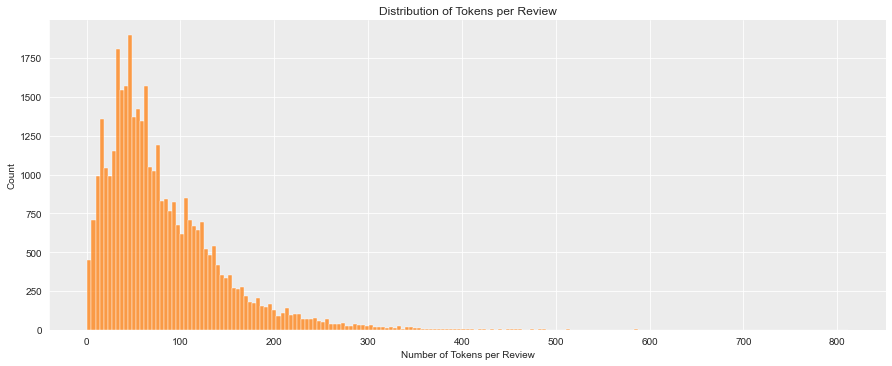

In [10]:
sns.set_style("darkgrid", {"axes.facecolor": ".925"})
sns.displot(df_reviews, x='tokens', color="tab:orange", aspect=2.5)
plt.xlabel('Number of Tokens per Review')
plt.ylabel('Count')
plt.title('Distribution of Tokens per Review')
plt.savefig('../reports/figures/distribution-tokens-per-review.png')
plt.show()

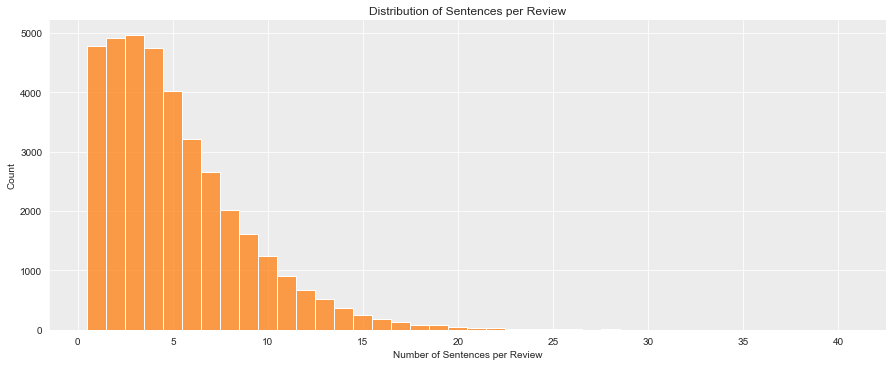

In [11]:
sns.displot(data=df_reviews, x='sents', aspect=2.5, color="tab:orange", kind="hist", discrete=True)
plt.xlabel('Number of Sentences per Review')
plt.ylabel('Count')
plt.title('Distribution of Sentences per Review')
plt.savefig('../reports/figures/distribution-sentences-per-review.png')
plt.show()

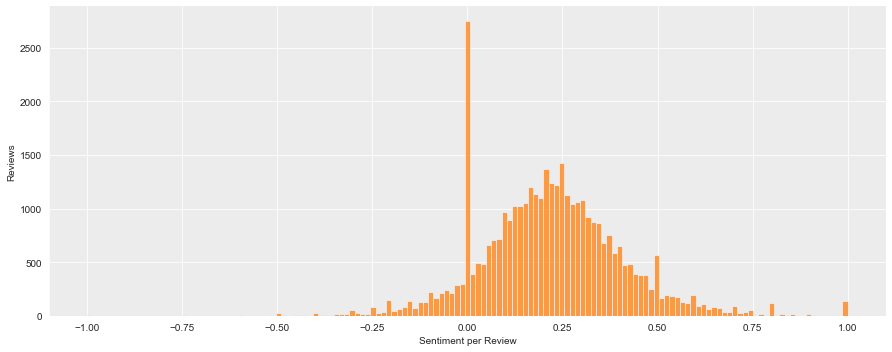

In [12]:
sns.displot(data=df_reviews, x='sentiment', aspect=2.5, color="tab:orange")
plt.xlabel('Sentiment per Review')
plt.ylabel('Reviews')
sns.despine()
plt.show()

In [13]:
# Number of tokens
num_tokens = df_reviews['tokens'].sum()
print (f"There are {num_tokens} tokens.")

There are 3022223 tokens.


In [14]:
# Number of raw "words"
text = " ".join(review for review in df_reviews.review_text)
print (f"There are {len(text)} words.")

There are 14193155 words.


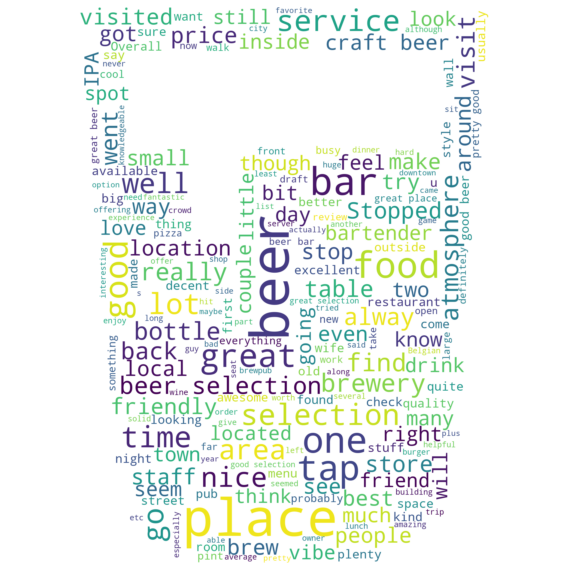

In [38]:
# Generate and save a word cloud image
mask = np.array(Image.open("../reports/icons/beer-pint-2048.png"))
wordcloud = WordCloud(background_color="white", mask=mask).generate(text)
wordcloud.to_file('../reports/figures/word-cloud-beer-pint.png')

# Show image
plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

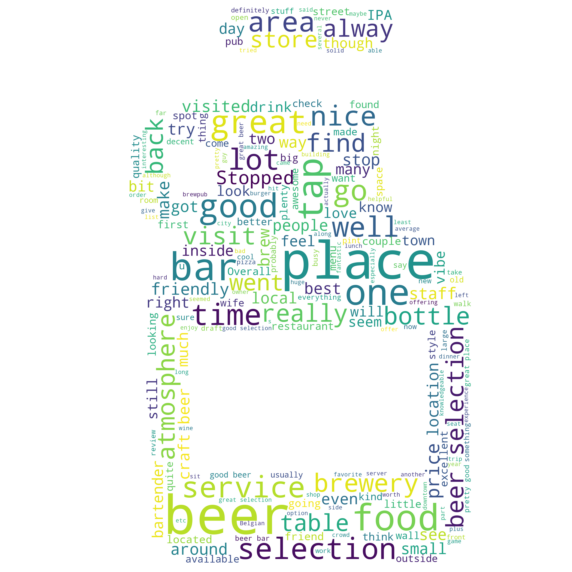

In [39]:
# Generate and save a word cloud image
mask = np.array(Image.open("../reports/icons/growler-2048.png"))
wordcloud = WordCloud(background_color="white", mask=mask).generate(text)
wordcloud.to_file('../reports/figures/word-cloud-growler.png')

# Show image
plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

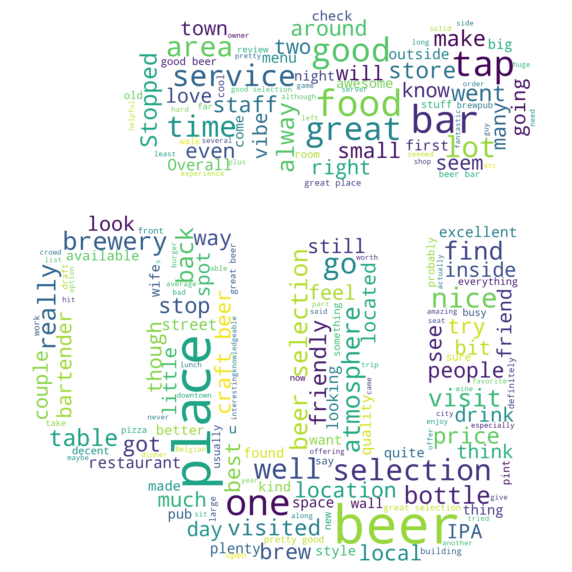

In [40]:
# Generate and save a word cloud image
mask = np.array(Image.open("../reports/icons/beer-mug-2048.png"))
wordcloud = WordCloud(background_color="white", mask=mask).generate(text)
wordcloud.to_file('../reports/figures/word-cloud-beer-mug.png')

# Show image
plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()